In [ ]:
from datetime import datetime
print("Date:", datetime.today().strftime('%Y-%m-%d'))

## 📂 Project Overview

In this notebook, we analyze natural gas consumption in Uşak (2015–2018) using **unsupervised learning**. The objective is to uncover patterns in seasonal consumption, identify exchange rate-sensitive groups, detect anomalies, and explore geospatial profiles using clustering techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

## 📊 Data Exploration

We load and inspect the dataset, focusing on monthly consumption values and exchange rate columns. Initial checks reveal some missing values, which we later handle.


In [2]:
# Load and preview
print("Reading dataset...")
data = pd.read_excel("01-Clustering Usak Natural Gas Consumption.xlsx")
print("First 5 rows:\n", data.head())

# Basic info
print("\nDataset Info:")
data.info()
print("\nDataset Description:\n", data.describe())

Reading dataset...
First 5 rows:
    Year  Jan usd/tr  Feb usd/tr  Mar usd/tr  Apr usd/tr  May usd/tr  \
0  2015      2.3449      2.4236      2.5187      2.6008      2.7109   
1  2015      2.3449      2.4236      2.5187      2.6008      2.7109   
2  2018      3.7652      3.7567      3.8082      3.9577      4.1208   
3  2016      2.9422      2.9671      2.9451      2.8197      2.7928   
4  2016      2.9422      2.9671      2.9451      2.8197      2.7928   

   Jun usd/tr  Jul usd/tr  Aug usd/tr  Sep usd/tr  ...    Apr   May    Jun  \
0      2.6762      2.6992      2.7736      2.9147  ...   0.00  0.00   0.00   
1      2.6762      2.6992      2.7736      2.9147  ...   0.00  0.00   0.00   
2      4.5922      4.6225      4.9223      6.6213  ...  12.25  7.44   8.30   
3      2.9489      2.8846      2.9797      2.9558  ...   0.00  0.00   7.50   
4      2.9489      2.8846      2.9797      2.9558  ...  14.30  9.36  12.03   

     Jul    Aug    Sep    Oct    Nov    Dec   Total  
0   0.00   0.00 

## 🌀 Pattern-Based Consumption Clustering

To identify seasonal consumption patterns, we use **KMeans clustering** on normalized monthly usage. We reduce dimensions using PCA for visualization and examine the structure of clusters.


In [3]:
# Define month columns
monthly_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Drop rows with all missing monthly values
X_monthly = data[monthly_cols].dropna(how='all')
print(f"\nRemaining rows after dropping empty: {len(X_monthly)}")

# Fill missing with column mean
X_monthly = X_monthly.fillna(X_monthly.mean())

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_monthly)



# KMeans clustering for pattern
print("Running KMeans for pattern clustering...")
pattern_model = KMeans(n_clusters=4, random_state=13)
pattern_labels = pattern_model.fit_predict(X_scaled)

data['pattern_cluster'] = pattern_labels


Remaining rows after dropping empty: 215871
Running KMeans for pattern clustering...


c:\Users\ekinc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ekinc\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


C:\Users\ekinc\AppData\Local\Temp\ipykernel_10984\3397650104.py:16: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ekinc\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


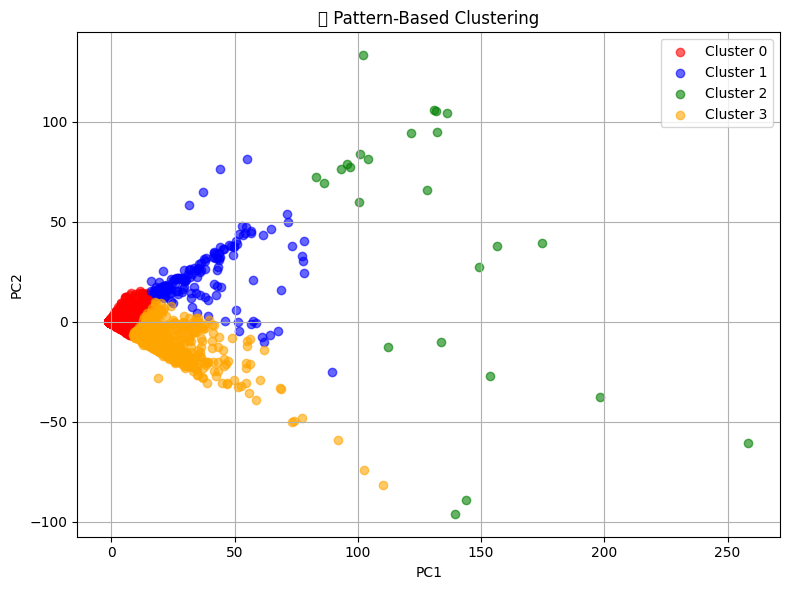

In [4]:
# PCA for visual
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    idx = pattern_labels == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Cluster {i}", color=colors[i], alpha=0.6)
plt.title("🌀 Pattern-Based Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 💱 Clustering Based on Exchange Rate Influence

To understand if certain consumers are influenced by currency fluctuations, we combine monthly exchange rates and gas usage, then apply **Agglomerative Clustering**. We visualize cluster trends to identify sensitivity.


In [7]:
# Clustering based on monthly + exchange rates
rate_cols = [col for col in data.columns if 'usd/tr' in col.lower()]
X_combo = data[rate_cols + monthly_cols].dropna()

X_combo_scaled = scaler.fit_transform(X_combo)

from sklearn.cluster import MiniBatchKMeans

print("Running MiniBatchKMeans...")
kmeans_model = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
combo_labels = kmeans_model.fit_predict(X_combo_scaled)
data.loc[X_combo.index, 'exchange_rate_cluster'] = combo_labels

Running MiniBatchKMeans...


C:\Users\ekinc\AppData\Local\Temp\ipykernel_10984\4057064914.py:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x500 with 0 Axes>

C:\Users\ekinc\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


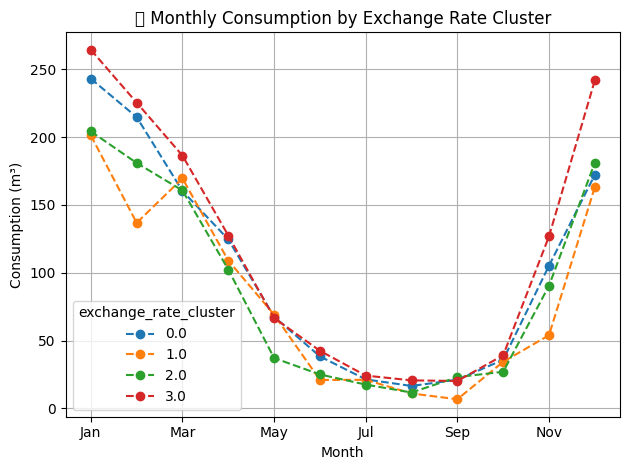

In [8]:
# Visualize consumption by cluster
plt.figure(figsize=(10, 5))
data.groupby('exchange_rate_cluster')[monthly_cols].mean().T.plot(marker='o', linestyle='--')
plt.title("📈 Monthly Consumption by Exchange Rate Cluster")
plt.ylabel("Consumption (m³)")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🚨 Anomaly Detection

We apply **Isolation Forest** to spot unusual yearly consumption profiles that may represent errors or atypical usage behaviors. Anomalies are flagged for further inspection.


In [9]:
# Anomaly Detection
print("Detecting anomalies with Isolation Forest...")
iso_model = IsolationForest(contamination=0.05, random_state=13)
anomaly_labels = iso_model.fit_predict(X_scaled)
data['anomaly'] = np.where(anomaly_labels == -1, 1, 0)

print("Total anomalies detected:", data['anomaly'].sum())

Detecting anomalies with Isolation Forest...
Total anomalies detected: 10794


## 📏 Cluster Evaluation

To validate the clustering result from pattern-based grouping, we compute the **Silhouette Score**, which reflects how well each point fits within its cluster. Higher values indicate more distinct clustering.


In [ ]:
# Silhouette Score
def evaluate_cluster(X, labels):
    print("Calculating Silhouette Score...")
    score = silhouette_score(X, labels)
    print(f"Silhouette Score: {score:.4f}")

evaluate_cluster(X_scaled, pattern_labels)

Calculating Silhouette Score...
